# EpiNano curlcake dataset exploration

**Author:** A. Fonzino

In Liu et al., 2019, researchers produced a dataset by sequencing a library of 4 *in-vitro* transcribed synthetic sequences of mRNA with both GriION and MinION (the latter for the second replicated used in this notebook). <br>
MinKNOW sofware v. 1.15.1 has been used during acquisitions and reads were locally base-called using Albacore 2.1.7 (ONT). Base-Called reads were filtered using NanoFilt, a component of Nanopack with settings "-q 0 -headcrop 5 -tailcrop 3", and mapped to the 4 synthetic sequences using minimap2 with settings "-ax map-ont". Mapped reads were then converted into mpileup format using Samtools version 1.4. <br>
Per-site features, BAM alignment files were converted to tab delimited format usign sam2tsv from jvarkit. For each reference site, the mean quality of the aligned bases, the mismatch, insertion, and deletion frequency was computed using in-house scripts made by researchers. To extract current intensity information from individual reads, the h5py (v. 2.7.0) and ont_fast5_api Python modules were used to parse each individual fast5 file. Reference sequences were slided with a window size of 5 bp, and mean and S.D. of current intesities was computed for each sliding window. 


In [1]:
# importing basic modules
import h5py
from ont_fast5_api.fast5_interface import get_fast5_file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
from tqdm import tqdm
from ont_custom_functions import *

## Importing data
Data are sparse in a very high number of differents files and folders. Thus there is the need to map all of these in a structured manner, in order to retrieve them easily. A lot of information are also present in the output file’s names of the GridION instrumentation (i.e. fast5 filename), thus I will use a Pandas DataFrame object to collect them.

In [2]:
# folder url of m6A modified sequences reads.
mod_url = r"C:\Users\adria\Desktop\EpiNanoDataset\Curlcake_constructs_m6A_modified_Replicate 1\fast5"
# # folder url of unmodified sequences reads.
unmod_url = r"C:\Users\adria\Desktop\EpiNanoDataset\Curlcake_constructs_unmodified_Replicate_1\fast5"

Since each fast5 file has a standardized name structure here I will extract these information related to each read in order to create a Pandas DataFrame where to store informations. 

In [3]:
# retieve all fast5 files names.
mod_file_names = []
mod_file_paths = []
unmod_file_names = []
unmod_file_paths = []

for i in os.listdir(mod_url):
    mod_file_paths += [os.path.join(mod_url, i)] * len(os.listdir(os.path.join(mod_url, i)))
    mod_file_names += os.listdir(os.path.join(mod_url, i))

for i in os.listdir(unmod_url):
    unmod_file_paths += [os.path.join(unmod_url, i)] * len(os.listdir(os.path.join(unmod_url, i)))
    unmod_file_names += os.listdir(os.path.join(unmod_url, i))

print("- Modified m6A reads number:", len(mod_file_names))
print("- Unmodified reads number", len(unmod_file_names))
print("- Total reads number:", len(mod_file_names)+len(unmod_file_names))

- Modified m6A reads number: 134374
- Unmodified reads number 66736
- Total reads number: 201110


In [4]:
import datetime

infos = []

# Consolidating dataset information in the pandas Dataframe for m6a modified reads
for read_name, read_path in zip(mod_file_names, mod_file_paths):
    read_info = {}
    read_info["data"] = read_name.split(".")[0].split("_")[1]
    read_info["FlowcellID"] = read_name.split(".")[0].split("_")[2]
    read_info["DeviceID"] = read_name.split(".")[0].split("_")[3]
    read_info["read_type"] = "_".join(read_name.split(".")[0].split("_")[4:6]) 
    read_info["SampleName"] = read_name.split(".")[0].split("_")[6]
    read_info["read"] = int(read_name.split(".")[0].split("_")[9])
    read_info["channel"] = int(read_name.split(".")[0].split("_")[11])
    read_info["m6A"] = "Yes" # field to say if the reads is from mod. or unmod. sequence
    read_info["path"] = os.path.join(read_path, read_name) # absolute path for the read fast5 file
    infos.append(read_info)

# Consolidating dataset information in the pandas Dataframe for unmodified reads
for read_name, read_path in zip(unmod_file_names, unmod_file_paths):
    read_info = {}
    read_info["data"] = read_name.split(".")[0].split("_")[1]
    read_info["FlowcellID"] = read_name.split(".")[0].split("_")[2]
    read_info["DeviceID"] = read_name.split(".")[0].split("_")[3]
    read_info["read_type"] = "_".join(read_name.split(".")[0].split("_")[4:6]) 
    read_info["SampleName"] = read_name.split(".")[0].split("_")[6]
    read_info["read"] = int(read_name.split(".")[0].split("_")[9])
    read_info["channel"] = int(read_name.split(".")[0].split("_")[11])
    read_info["m6A"] = "No" # field to say if the reads is from mod. or unmod. sequence
    read_info["path"] = os.path.join(read_path, read_name) # absolute path for the read fast5 file
    infos.append(read_info)

df_curlcake_reads = pd.DataFrame(infos)
df_curlcake_reads

data FlowcellID DeviceID       read_type   SampleName  read  \
0       20180726   FAH84534  GA20000        mux_scan  RNAAB090763    10   
1       20180726   FAH84534  GA20000        mux_scan  RNAAB090763    10   
2       20180726   FAH84534  GA20000        mux_scan  RNAAB090763    11   
3       20180726   FAH84534  GA20000        mux_scan  RNAAB090763    11   
4       20180726   FAH84534  GA20000        mux_scan  RNAAB090763    11   
...          ...        ...      ...             ...          ...   ...   
201105  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716   990   
201106  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716  9913   
201107  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716   998   
201108  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716  9997   
201109  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716  9999   

        channel  m6A                                               path  
0           472  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
1            76  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
2           329  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
3           461  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
4            67  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
...         ...  ...                                                ...  
201105       11   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
201106      438   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
201107       47   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
201108      475   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
201109      473   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  

[201110 rows x 9 columns]

## Exploratory Data Analysis

In [5]:
df_curlcake_reads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201110 entries, 0 to 201109
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   data        201110 non-null  object
 1   FlowcellID  201110 non-null  object
 2   DeviceID    201110 non-null  object
 3   read_type   201110 non-null  object
 4   SampleName  201110 non-null  object
 5   read        201110 non-null  int64 
 6   channel     201110 non-null  int64 
 7   m6A         201110 non-null  object
 8   path        201110 non-null  object
dtypes: int64(2), object(7)
memory usage: 13.8+ MB


In [6]:
for i in df_curlcake_reads.columns:
    print(i, "\n", df_curlcake_reads[i].value_counts(), "\n")

data 
 20180726    200120
20180727       990
Name: data, dtype: int64 

FlowcellID 
 FAH84534    134374
FAH85615     66736
Name: FlowcellID, dtype: int64 

DeviceID 
 GA20000    134374
GA10000     66736
Name: DeviceID, dtype: int64 

read_type 
 sequencing_run    200995
mux_scan             115
Name: read_type, dtype: int64 

SampleName 
 RNAAB090763    134374
RNAAB089716     66736
Name: SampleName, dtype: int64 

read 
 24       29
1917     28
785      27
10       27
1315     26
         ..
45002     1
62898     1
52661     1
42424     1
42674     1
Name: read, Length: 44588, dtype: int64 

channel 
 273    1189
142    1006
193     983
258     983
339     953
       ... 
91       13
382      11
250       9
121       3
309       1
Name: channel, Length: 507, dtype: int64 

m6A 
 Yes    134374
No      66736
Name: m6A, dtype: int64 

path 
 C:\Users\adria\Desktop\EpiNanoDataset\Curlcake_constructs_m6A_modified_Replicate 1\fast5\1204665-9.fast5\GXB01170_20180726_FAH84534_GA20000_sequencin

Investigating better **read** and **channel** fields.

In [7]:
df_curlcake_reads["channel"].value_counts()

273    1189
142    1006
193     983
258     983
339     953
       ... 
91       13
382      11
250       9
121       3
309       1
Name: channel, Length: 507, dtype: int64

In [8]:
# selecting rows/reads of the channel number 273 for the sake of example that has 1189 reads.
df_curlcake_reads.query("channel == 273")

data FlowcellID DeviceID       read_type   SampleName  read  \
1833    20180726   FAH84534  GA20000  sequencing_run  RNAAB090763   257   
2028    20180726   FAH84534  GA20000  sequencing_run  RNAAB090763   279   
2248    20180726   FAH84534  GA20000  sequencing_run  RNAAB090763    29   
2452    20180726   FAH84534  GA20000  sequencing_run  RNAAB090763    31   
2701    20180726   FAH84534  GA20000  sequencing_run  RNAAB090763   345   
...          ...        ...      ...             ...          ...   ...   
200878  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716  4682   
200929  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716   545   
200958  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716  6085   
200959  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716   608   
200996  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716  6891   

        channel  m6A                                               path  
1833        273  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
2028        273  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
2248        273  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
2452        273  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
2701        273  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
...         ...  ...                                                ...  
200878      273   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
200929      273   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
200958      273   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
200959      273   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
200996      273   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  

[1189 rows x 9 columns]

In [9]:
df_curlcake_reads.query("channel == 273")["m6A"].value_counts()

Yes    880
No     309
Name: m6A, dtype: int64

In [10]:
df_curlcake_reads.query("channel == 273")["read"].value_counts().describe()

count    1181.000000
mean        1.006774
std         0.082059
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: read, dtype: float64

Here we a duplicated read number. Go for further investigations.

In [11]:
df_curlcake_reads.query("channel == 273")["read"].value_counts()

73       2
18209    2
18499    2
7992     2
5276     2
        ..
36183    1
21848    1
46425    1
7517     1
20485    1
Name: read, Length: 1181, dtype: int64

In [12]:
df_curlcake_reads.query("read == 73 & channel == 273")

data FlowcellID DeviceID       read_type   SampleName  read  \
6624    20180726   FAH84534  GA20000  sequencing_run  RNAAB090763    73   
140916  20180726   FAH85615  GA10000  sequencing_run  RNAAB089716    73   

        channel  m6A                                               path  
6624        273  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
140916      273   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...

Thus as we can see the read number is not unique in different samples and experiments. And also, obviously the channel number. The only way to have a unique read with this dataset, is to consider all these columns together. Now we'll see the total number of duplicated reads/occurrences in the entire dataset and the in m6A and umodified subsets.

In [13]:
# whole dataset
df_curlcake_reads[["read", "channel"]].duplicated().value_counts()

False    200373
True        737
dtype: int64

In [14]:
# m6A subset
df_curlcake_reads.query("m6A == 'Yes'").duplicated(["read", "channel"], keep=False).value_counts()

False    134366
True          8
dtype: int64

In [15]:
# unmodified subset
df_curlcake_reads.query("m6A == 'No'").duplicated(["read", "channel"], keep=False).value_counts()

False    66720
True        16
dtype: int64

How!? It's very strange! We've got in both the subsets duplicated rows.

In [16]:
df_curlcake_reads.query("m6A == 'Yes'")[df_curlcake_reads.query("m6A == 'Yes'").duplicated(["read", "channel"], keep="last")]

data FlowcellID DeviceID       read_type   SampleName  read  \
8     20180726   FAH84534  GA20000        mux_scan  RNAAB090763    12   
17    20180726   FAH84534  GA20000        mux_scan  RNAAB090763   154   
60    20180726   FAH84534  GA20000        mux_scan  RNAAB090763    75   
4077  20180726   FAH84534  GA20000  sequencing_run  RNAAB090763   481   

      channel  m6A                                               path  
8         331  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
17        153  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
60         19  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
4077      293  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...

In [17]:
df_curlcake_reads.query("m6A == 'No'")[df_curlcake_reads.query("m6A == 'No'").duplicated(["read", "channel"], keep="last")]

data FlowcellID DeviceID       read_type   SampleName   read  \
134399  20180726   FAH85615  GA10000        mux_scan  RNAAB089716     49   
138826  20180726   FAH85615  GA10000  sequencing_run  RNAAB089716    350   
142153  20180726   FAH85615  GA10000  sequencing_run  RNAAB089716     95   
144914  20180726   FAH85615  GA10000  sequencing_run  RNAAB089716   2126   
152425  20180726   FAH85615  GA10000  sequencing_run  RNAAB089716   3739   
159773  20180726   FAH85615  GA10000  sequencing_run  RNAAB089716   5449   
169870  20180726   FAH85615  GA10000  sequencing_run  RNAAB089716   7188   
187107  20180726   FAH85615  GA10000  sequencing_run  RNAAB089716  20919   

        channel m6A                                               path  
134399      474  No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
138826      470  No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
142153      474  No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
144914      474  No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
152425      166  No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
159773      181  No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
169870      266  No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...  
187107      211  No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...

We should drop these duplicates!

In [18]:
index_m6a_drop = df_curlcake_reads.query("m6A == 'Yes'")[
    df_curlcake_reads.query("m6A == 'Yes'").duplicated(["read", "channel"], keep="last")].index

index_unmod_drop = df_curlcake_reads.query("m6A == 'No'")[
    df_curlcake_reads.query("m6A == 'No'").duplicated(["read", "channel"], keep="last")].index

In [19]:
df_curlcake_reads.drop(index_m6a_drop, inplace=True)
df_curlcake_reads.drop(index_unmod_drop, inplace=True)

In [20]:
df_curlcake_reads.shape

(201098, 9)

And now go to analyse channels

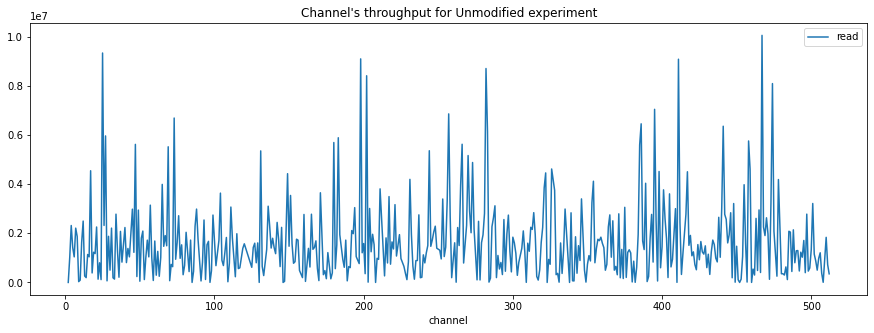

In [21]:
df_curlcake_reads[df_curlcake_reads["m6A"]=="No"][["read", "channel"]].groupby("channel").sum().plot(figsize=(15,5))
plt.title("Channel's throughput for Unmodified experiment")
plt.show()

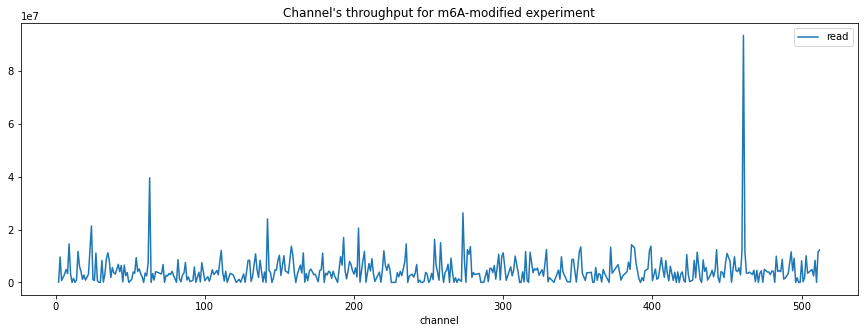

In [22]:
df_curlcake_reads[df_curlcake_reads["m6A"]=="Yes"][["read", "channel"]].groupby("channel").sum().plot(figsize=(15,5))
plt.title("Channel's throughput for m6A-modified experiment")
plt.show()

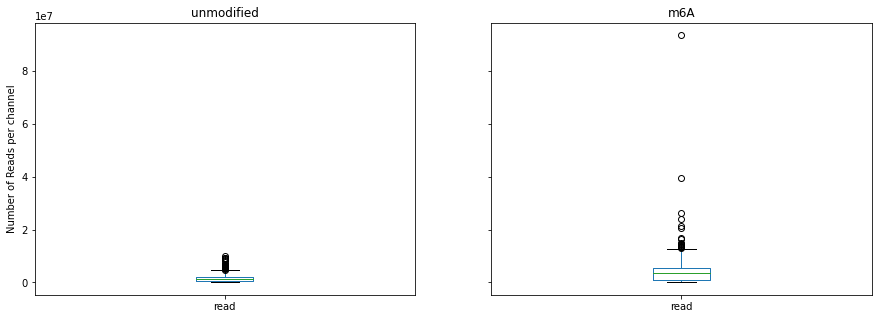

In [23]:
f, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
df_curlcake_reads[df_curlcake_reads["m6A"]=="No"][["read", "channel"]].groupby("channel").sum().plot(
    kind="box", 
    title="unmodified", 
    ylabel="Number of Reads per channel",
    ax=ax[0])
df_curlcake_reads[df_curlcake_reads["m6A"]=="Yes"][["read", "channel"]].groupby("channel").sum().plot(
    kind="box", 
    title="m6A", 
    ax=ax[1])
plt.show()

It's important for the subsequent analysis to add some field to the dataframe with the information. For example it could be very useful to found how many fast5 file have fastq sequences stored inside itself. So, in this way we could, on one hand decrease the number of samples and, on the other hand, increase the possibilities of a better results investigation, working on the original fastq sequences give by the instument. 

In [41]:
# retrieve information about the presence of fastq inside each fast5 file and storing it as a boolean
# list to be added as dataframe columns. Here the iteration is also used to retrieve the read_id of 
# each read.

has_fastq = []
read_ids = []
with tqdm(total=len(df_curlcake_reads.path.tolist())) as pbar:
    for i in df_curlcake_reads.path:
        f5 = get_fast5_file(i)
        read_ids.append(f5.read_id)
        if f5.get_analysis_dataset("Basecall_1D_000/BaseCalled_template", "Fastq"):
            has_fastq.append("Yes")
        else:
            has_fastq.append("No")
        pbar.update(1)

100%|██████████| 201098/201098 [17:01<00:00, 196.89it/s]


In [42]:
print(len(has_fastq))
print(len(read_ids))

201098
201098


In [43]:
print(len(has_fastq) == df_curlcake_reads.shape[0])
print(len(read_ids) == df_curlcake_reads.shape[0])

True
True


In [44]:
df_curlcake_reads["fastq"] = has_fastq
df_curlcake_reads["read_id"] = read_ids
df_curlcake_reads

data FlowcellID DeviceID       read_type   SampleName  read  \
0       20180726   FAH84534  GA20000        mux_scan  RNAAB090763    10   
1       20180726   FAH84534  GA20000        mux_scan  RNAAB090763    10   
2       20180726   FAH84534  GA20000        mux_scan  RNAAB090763    11   
3       20180726   FAH84534  GA20000        mux_scan  RNAAB090763    11   
4       20180726   FAH84534  GA20000        mux_scan  RNAAB090763    11   
...          ...        ...      ...             ...          ...   ...   
201105  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716   990   
201106  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716  9913   
201107  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716   998   
201108  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716  9997   
201109  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716  9999   

        channel  m6A                                               path fastq  \
0           472  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
1            76  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...    No   
2           329  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
3           461  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
4            67  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
...         ...  ...                                                ...   ...   
201105       11   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
201106      438   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
201107       47   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
201108      475   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
201109      473   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...    No   

                                     read_id  
0       5ba8d6a5-e25b-4688-9b55-1372bcd2cbd2  
1       4810658b-f383-49e4-9044-050d963aff73  
2       9cfa4d57-5c0a-42e2-a465-b750fde2a4f5  
3       6b45af1c-0ebd-4221-949f-1770d44f620c  
4       65647aa4-0a09-450a-992c-0e50ade5ebb1  
...                                      ...  
201105  ef500690-339e-48e1-8f5d-c2cc18f0cdec  
201106  1394ac01-7b5c-4c7b-bb85-9dedc40e009e  
201107  fca55b0b-1542-4bc2-9423-f734b1334df6  
201108  e4ed8bc2-6a25-4c33-8a2f-e160f6cd9f4d  
201109  b794d625-acbf-4a66-9d41-c6a1f55ef955  

[201098 rows x 11 columns]

In [65]:
# asserting that read id is unique for every read into the dataset.
np.unique(df_curlcake_reads.read_id).shape[0] == df_curlcake_reads.read_id.shape[0]

True

In the end, another way to univocally identify the read is to use the **read_id** attribute of the fast5 file.

In [61]:
df_curlcake_reads.query("(fastq == 'Yes') & (read_type != 'mux_scan')")

data FlowcellID DeviceID       read_type   SampleName  read  \
77      20180726   FAH84534  GA20000  sequencing_run  RNAAB090763  1000   
78      20180726   FAH84534  GA20000  sequencing_run  RNAAB090763  1001   
79      20180726   FAH84534  GA20000  sequencing_run  RNAAB090763  1001   
80      20180726   FAH84534  GA20000  sequencing_run  RNAAB090763  1002   
81      20180726   FAH84534  GA20000  sequencing_run  RNAAB090763  1003   
...          ...        ...      ...             ...          ...   ...   
201102  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716   971   
201105  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716   990   
201106  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716  9913   
201107  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716   998   
201108  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716  9997   

        channel  m6A                                               path fastq  \
77          322  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
78          407  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
79          475  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
80          393  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
81          407  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
...         ...  ...                                                ...   ...   
201102      395   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
201105       11   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
201106      438   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
201107       47   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
201108      475   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   

                                     read_id  
77      81917ed9-47ad-430a-989f-e4e096a1ba4d  
78      4d79fd54-f52f-47c4-adfc-c935242343ca  
79      031de4f1-14ab-4fe5-b190-dcaafa8fcb94  
80      2b7b81e9-9f78-4a1b-9185-9b5950a9856c  
81      4eab2e94-c571-4f96-9a0a-0d01f38fb221  
...                                      ...  
201102  3f8f5fb6-b9fa-4ec6-a3d1-f907520d4dc5  
201105  ef500690-339e-48e1-8f5d-c2cc18f0cdec  
201106  1394ac01-7b5c-4c7b-bb85-9dedc40e009e  
201107  fca55b0b-1542-4bc2-9423-f734b1334df6  
201108  e4ed8bc2-6a25-4c33-8a2f-e160f6cd9f4d  

[193926 rows x 11 columns]

Summarizing, excluding the *mux_scan* samples, 193926 of 210100 reads have fastq file stored. Now I'd like to explore the distribution of raw reads lenght.

In [127]:
read_lenghts = [] # storing all the lenghts
read_max = [] # storing all the maximum values
read_min = [] # storing all the minimum values
read_mean = [] # storing all the mean values
read_median = [] # storing all the median values
read_std = [] # storing all the standard deviation values

with tqdm(total=len(df_curlcake_reads.path.tolist())) as pbar:
    for i in df_curlcake_reads.path:
        f5 = get_fast5_file(i)
        read_lenghts.append(raw_to_pA(f5).shape[0])
        read_max.append(raw_to_pA(f5).max())
        read_min.append(raw_to_pA(f5).min())
        read_mean.append(raw_to_pA(f5).mean())
        read_median.append(np.median(raw_to_pA(f5)))
        read_std.append(raw_to_pA(f5).std())
        pbar.update(1)

100%|██████████| 201098/201098 [1:06:50<00:00, 50.14it/s]


In [128]:
df_curlcake_reads["read_length"] = read_lenghts
df_curlcake_reads["read_max"] = read_max
df_curlcake_reads["read_min"] = read_min
df_curlcake_reads["read_mean"] = read_mean
df_curlcake_reads["read_median"] = read_median
df_curlcake_reads["read_std"] = read_std

In [ ]:
# saving it on disk to avoid repeating the same long iterations.
df_curlcake_reads.to_csv("df_curlcake_reads.csv")

In [2]:
# loading from disk
df_curlcake_reads = pd.read_csv("df_curlcake_reads.csv", index_col=0)
df_curlcake_reads

data FlowcellID DeviceID       read_type   SampleName  read  \
0       20180726   FAH84534  GA20000        mux_scan  RNAAB090763    10   
1       20180726   FAH84534  GA20000        mux_scan  RNAAB090763    10   
2       20180726   FAH84534  GA20000        mux_scan  RNAAB090763    11   
3       20180726   FAH84534  GA20000        mux_scan  RNAAB090763    11   
4       20180726   FAH84534  GA20000        mux_scan  RNAAB090763    11   
...          ...        ...      ...             ...          ...   ...   
201105  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716   990   
201106  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716  9913   
201107  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716   998   
201108  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716  9997   
201109  20180727   FAH85615  GA10000  sequencing_run  RNAAB089716  9999   

        channel  m6A                                               path fastq  \
0           472  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
1            76  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...    No   
2           329  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
3           461  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
4            67  Yes  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
...         ...  ...                                                ...   ...   
201105       11   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
201106      438   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
201107       47   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
201108      475   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...   Yes   
201109      473   No  C:\Users\adria\Desktop\EpiNanoDataset\Curlcake...    No   

                                     read_id  read_length    read_max  \
0       5ba8d6a5-e25b-4688-9b55-1372bcd2cbd2        29745  159.934707   
1       4810658b-f383-49e4-9044-050d963aff73         7371  158.763024   
2       9cfa4d57-5c0a-42e2-a465-b750fde2a4f5        23095  148.803720   
3       6b45af1c-0ebd-4221-949f-1770d44f620c        18422  130.056795   
4       65647aa4-0a09-450a-992c-0e50ade5ebb1        24781  156.859039   
...                                      ...          ...         ...   
201105  ef500690-339e-48e1-8f5d-c2cc18f0cdec        20830  133.765011   
201106  1394ac01-7b5c-4c7b-bb85-9dedc40e009e        11781  163.444554   
201107  fca55b0b-1542-4bc2-9423-f734b1334df6        42324  156.266246   
201108  e4ed8bc2-6a25-4c33-8a2f-e160f6cd9f4d        14216  150.468382   
201109  b794d625-acbf-4a66-9d41-c6a1f55ef955         8400  121.341016   

         read_min   read_mean  read_median   read_std  
0      -60.048745   92.866259    88.754975  17.639826  
1       56.973078   93.447985    88.462054  19.664399  
2      -25.923483   97.978946   102.522248  17.125145  
3       42.473503   84.011478    83.043021  13.411967  
4       60.781047   97.459209    93.002325  17.932371  
...           ...         ...          ...        ...  
201105  34.096964   87.068969    76.752679  22.079564  
201106  59.911264   98.440998    99.530003  20.359852  
201107  41.827449  104.962580   106.156134  19.633625  
201108  60.739530   93.015310    90.695162  17.067877  
201109  56.598199   98.717875   103.671335  11.502552  

[201098 rows x 17 columns]

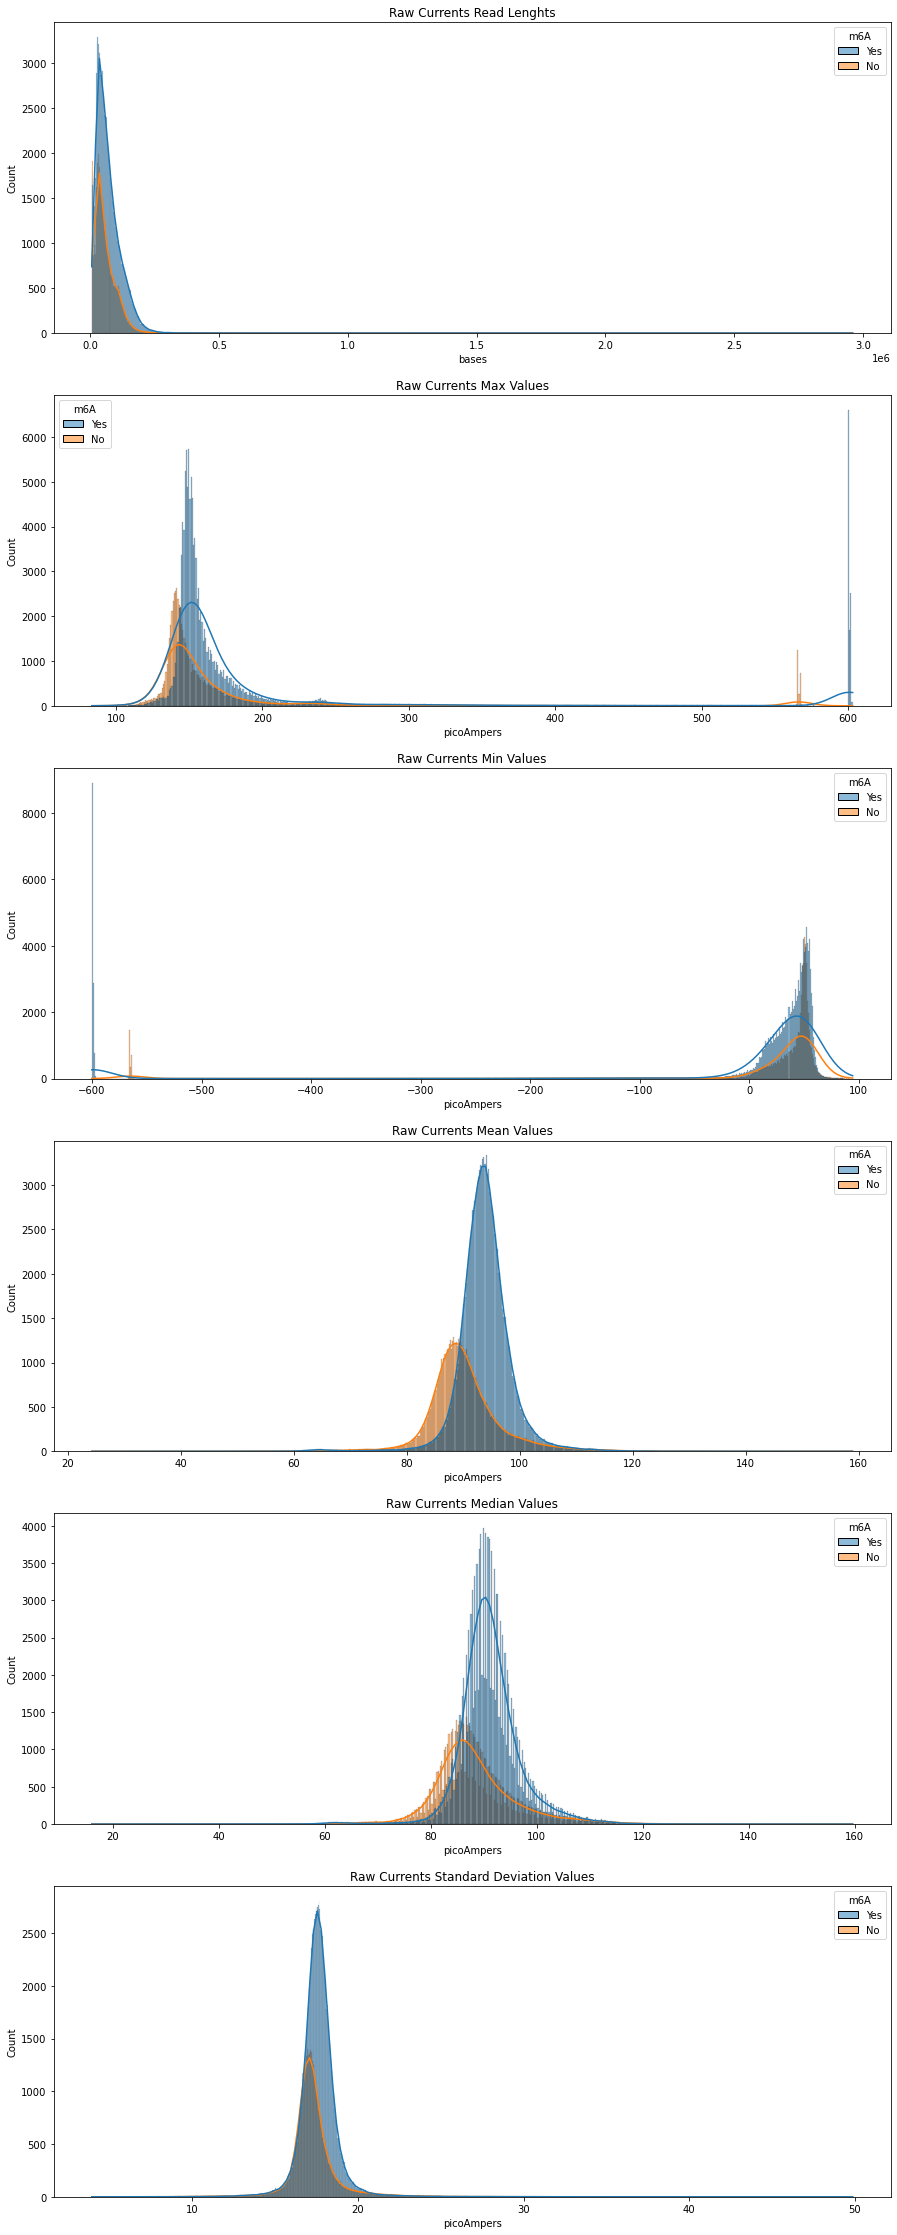

In [168]:
f, axes = plt.subplots(6, 1, figsize=(15, 40))

sn.histplot(df_curlcake_reads, x="read_length", kde=True, hue="m6A", ax=axes[0]).set_title("Raw Currents Read Lenghts")
axes[0].set_xlabel("bases")
sn.histplot(df_curlcake_reads, x="read_max", kde=True, hue="m6A", ax=axes[1]).set_title("Raw Currents Max Values")
axes[1].set_xlabel("picoAmpers")
sn.histplot(df_curlcake_reads, x="read_min", kde=True, hue="m6A", ax=axes[2]).set_title("Raw Currents Min Values")
axes[2].set_xlabel("picoAmpers")
sn.histplot(df_curlcake_reads, x="read_mean", kde=True, hue="m6A", ax=axes[3]).set_title("Raw Currents Mean Values")
axes[3].set_xlabel("picoAmpers")
sn.histplot(df_curlcake_reads, x="read_median", kde=True, hue="m6A", ax=axes[4]).set_title("Raw Currents Median Values")
axes[4].set_xlabel("picoAmpers")
sn.histplot(df_curlcake_reads, x="read_std", kde=True, hue="m6A", ax=axes[5]).set_title("Raw Currents Standard Deviation Values")
axes[5].set_xlabel("picoAmpers")
plt.show()

## Fastq content Analysis
Now in this section I am going to analyse the fastq contents of the reads.

In [91]:
# Consolidate all fastq reads into two different .fastq files, one for Unmodified reads and one for the m6A reads.
f = open("m6A.fastq", "w")
with tqdm(total=df_curlcake_reads.query("(fastq == 'Yes') & (read_type != 'mux_scan') & (m6A == 'Yes')").shape[0]) as pbar:
    for i in df_curlcake_reads.query("(fastq == 'Yes') & (read_type != 'mux_scan') & (m6A == 'Yes')").itertuples():
        f5 = get_fast5_fisle(i.path)
        f.write(get_fastq(f5, only_sequence=False))
        f.write("\n")
        pbar.update(1)
f.close()

100%|██████████| 130923/130923 [11:28<00:00, 190.11it/s]


In [92]:
f = open("unmod.fastq", "w")
with tqdm(total=df_curlcake_reads.query("(fastq == 'Yes') & (read_type != 'mux_scan') & (m6A == 'No')").shape[0]) as pbar:
    for i in df_curlcake_reads.query("(fastq == 'Yes') & (read_type != 'mux_scan') & (m6A == 'No')").itertuples():
        f5 = get_fast5_file(i.path)
        f.write(get_fastq(f5, only_sequence=False))
        f.write("\n")
        pbar.update(1)
f.close()

100%|██████████| 63003/63003 [05:39<00:00, 185.71it/s]


In [7]:
fastq_unmod_path = "unmod.fastq"
fastq_m6a_path = "m6A.fastq"

The fastq files have been analyzed on a bash terminal with the use of the quality control suite "fastqc". Report have been generated as html files.
## Curlcake Analysis

After that, I focused on the 4 Curlcake sequences that are provided by researcher as fasta file with 4 sequences. I'm going here to retrieve these sequences in order to merge them into a single sequence named *whole_curlcake* of ~10kbases.

In [1]:
fasta_curlcakes = r"C:\Users\adria\Desktop\EpiNanoDataset\cc.fasta"

In [2]:
# Retrieving the sequences from the fasta file.
f = open(fasta_curlcakes, "r")
fastas = f.read()
f.close()
fastas

'>cc6m_2244_T7_ecorv\nATCATAATTAATACGACTCACTATAGGGAGATCCGGCTGTGGAAGTCGATGAATCAAAAACCTTGGACCCTATCTCACAACGAACGAGTAATCCTGCGTGGGACTACAAAGTCGTTTTCGTGGACCAGGCCTCGACCTCCCAAGCATATGGGGACGTCGCTCAAATCCACAGTAGACTATCTATTAACTAATTGTGGATCGATGCTGACGCTACCCAGGTCTAGTTCGAGCCAATAATGTGCTACGTCGCGAAAGCCAAACAACGCTAACACCCTATCGTTCATTTGATACGTAACATCAATCACCTTGCAACTAGCTCGAACGGTATGGTTCAACGAGGGTGTTAGGCAGCGAACAACCCAGAGCGTTTATCATACCATATGCTCAACATACTTCCAGAGAGTCTGTTGGTCTAACAAGGTATAGCGGCGAGCAACGGAAAAGATAGTGCGTAATAGTTCGAGGAGCACCGCATCCCCCTCGCCGTTTTCGGGCCGTTAATATGGGCCGTAACACACCGGAGTTTCATAAAACGGCCTTTCCGTTGCTCGGGTGAGGGCATACGTGCTGCCTGGAGGGTATCCTACATGGTTAAATGCTGCGCCCCGTTAGGAAGCAGCAAATAAGAGTCTACCCGGTCTACCGGTACAAAGTTCGTGAGAGTTCTTCATGCTCGTCTCATAAAGGACTGGCAAAGGCCTTTGTTGCGTCAATGAGGAAGCCAAGCGGCGAGGTCAAGGCCACGAGTACATGGGCCATTCTCCAGTATAGTGAAATAAGCCCACGCGGTAAACCAAATGTGGAGCACACTCCACGTTCCTGTTCGTGGGCCTATTGGGATATGTCTTTATCAGACAACCTTATTTACGCGTATACATGCGGCAGTAGGCCTCGCGGTCCTAAGGGTCAGGTGTTACCACTTACCTCAATTTTCTCTGGAGTAGTACTTAGACTACCATCTTTGTTGAGAAATCATCT

In [3]:
# splitting into a list of sequences.
fastas.split("\n")

['>cc6m_2244_T7_ecorv',
 'ATCATAATTAATACGACTCACTATAGGGAGATCCGGCTGTGGAAGTCGATGAATCAAAAACCTTGGACCCTATCTCACAACGAACGAGTAATCCTGCGTGGGACTACAAAGTCGTTTTCGTGGACCAGGCCTCGACCTCCCAAGCATATGGGGACGTCGCTCAAATCCACAGTAGACTATCTATTAACTAATTGTGGATCGATGCTGACGCTACCCAGGTCTAGTTCGAGCCAATAATGTGCTACGTCGCGAAAGCCAAACAACGCTAACACCCTATCGTTCATTTGATACGTAACATCAATCACCTTGCAACTAGCTCGAACGGTATGGTTCAACGAGGGTGTTAGGCAGCGAACAACCCAGAGCGTTTATCATACCATATGCTCAACATACTTCCAGAGAGTCTGTTGGTCTAACAAGGTATAGCGGCGAGCAACGGAAAAGATAGTGCGTAATAGTTCGAGGAGCACCGCATCCCCCTCGCCGTTTTCGGGCCGTTAATATGGGCCGTAACACACCGGAGTTTCATAAAACGGCCTTTCCGTTGCTCGGGTGAGGGCATACGTGCTGCCTGGAGGGTATCCTACATGGTTAAATGCTGCGCCCCGTTAGGAAGCAGCAAATAAGAGTCTACCCGGTCTACCGGTACAAAGTTCGTGAGAGTTCTTCATGCTCGTCTCATAAAGGACTGGCAAAGGCCTTTGTTGCGTCAATGAGGAAGCCAAGCGGCGAGGTCAAGGCCACGAGTACATGGGCCATTCTCCAGTATAGTGAAATAAGCCCACGCGGTAAACCAAATGTGGAGCACACTCCACGTTCCTGTTCGTGGGCCTATTGGGATATGTCTTTATCAGACAACCTTATTTACGCGTATACATGCGGCAGTAGGCCTCGCGGTCCTAAGGGTCAGGTGTTACCACTTACCTCAATTTTCTCTGGAGTAGTACTTAGACTACCATCTTTGTTGAGAAATC

In [4]:
for i in [1,3,5,7]:
    print(len( fastas.split("\n")[i] ))

2276
2492
2625
2742


In [5]:
# Merging into a single sequence.
whole_curlcake = fastas.split("\n")[1] + fastas.split("\n")[3] + fastas.split("\n")[5] + fastas.split("\n")[7]
print("Length of whole_curlcake sequence: {} bases\n\nSequence:".format(len(whole_curlcake)))
print(whole_curlcake)

Length of whole_curlcake sequence: 10135 bases

Sequence:
ATCATAATTAATACGACTCACTATAGGGAGATCCGGCTGTGGAAGTCGATGAATCAAAAACCTTGGACCCTATCTCACAACGAACGAGTAATCCTGCGTGGGACTACAAAGTCGTTTTCGTGGACCAGGCCTCGACCTCCCAAGCATATGGGGACGTCGCTCAAATCCACAGTAGACTATCTATTAACTAATTGTGGATCGATGCTGACGCTACCCAGGTCTAGTTCGAGCCAATAATGTGCTACGTCGCGAAAGCCAAACAACGCTAACACCCTATCGTTCATTTGATACGTAACATCAATCACCTTGCAACTAGCTCGAACGGTATGGTTCAACGAGGGTGTTAGGCAGCGAACAACCCAGAGCGTTTATCATACCATATGCTCAACATACTTCCAGAGAGTCTGTTGGTCTAACAAGGTATAGCGGCGAGCAACGGAAAAGATAGTGCGTAATAGTTCGAGGAGCACCGCATCCCCCTCGCCGTTTTCGGGCCGTTAATATGGGCCGTAACACACCGGAGTTTCATAAAACGGCCTTTCCGTTGCTCGGGTGAGGGCATACGTGCTGCCTGGAGGGTATCCTACATGGTTAAATGCTGCGCCCCGTTAGGAAGCAGCAAATAAGAGTCTACCCGGTCTACCGGTACAAAGTTCGTGAGAGTTCTTCATGCTCGTCTCATAAAGGACTGGCAAAGGCCTTTGTTGCGTCAATGAGGAAGCCAAGCGGCGAGGTCAAGGCCACGAGTACATGGGCCATTCTCCAGTATAGTGAAATAAGCCCACGCGGTAAACCAAATGTGGAGCACACTCCACGTTCCTGTTCGTGGGCCTATTGGGATATGTCTTTATCAGACAACCTTATTTACGCGTATACATGCGGCAGTAGGCCTCGCGGTCCTAAGGGTCAGGTGTTACCACTTACCTCAATTTTCTCTGGAGT

In [6]:
# save it as fasta file.
with open("whole_curlcake.fasta", "w") as f:
    f.write(">whole_curlcake_sequence_epinano\n")
    f.write(whole_curlcake)
    f.close()

In [7]:
# read whole_curlcake.fasta from disk
with open("whole_curlcake.fasta", "r") as f:
    whole_curlcake_fasta = f.read()
    f.close()
whole_curlcake = whole_curlcake_fasta.split("\n")[1]
print(whole_curlcake_fasta)

>whole_curlcake_sequence_epinano
ATCATAATTAATACGACTCACTATAGGGAGATCCGGCTGTGGAAGTCGATGAATCAAAAACCTTGGACCCTATCTCACAACGAACGAGTAATCCTGCGTGGGACTACAAAGTCGTTTTCGTGGACCAGGCCTCGACCTCCCAAGCATATGGGGACGTCGCTCAAATCCACAGTAGACTATCTATTAACTAATTGTGGATCGATGCTGACGCTACCCAGGTCTAGTTCGAGCCAATAATGTGCTACGTCGCGAAAGCCAAACAACGCTAACACCCTATCGTTCATTTGATACGTAACATCAATCACCTTGCAACTAGCTCGAACGGTATGGTTCAACGAGGGTGTTAGGCAGCGAACAACCCAGAGCGTTTATCATACCATATGCTCAACATACTTCCAGAGAGTCTGTTGGTCTAACAAGGTATAGCGGCGAGCAACGGAAAAGATAGTGCGTAATAGTTCGAGGAGCACCGCATCCCCCTCGCCGTTTTCGGGCCGTTAATATGGGCCGTAACACACCGGAGTTTCATAAAACGGCCTTTCCGTTGCTCGGGTGAGGGCATACGTGCTGCCTGGAGGGTATCCTACATGGTTAAATGCTGCGCCCCGTTAGGAAGCAGCAAATAAGAGTCTACCCGGTCTACCGGTACAAAGTTCGTGAGAGTTCTTCATGCTCGTCTCATAAAGGACTGGCAAAGGCCTTTGTTGCGTCAATGAGGAAGCCAAGCGGCGAGGTCAAGGCCACGAGTACATGGGCCATTCTCCAGTATAGTGAAATAAGCCCACGCGGTAAACCAAATGTGGAGCACACTCCACGTTCCTGTTCGTGGGCCTATTGGGATATGTCTTTATCAGACAACCTTATTTACGCGTATACATGCGGCAGTAGGCCTCGCGGTCCTAAGGGTCAGGTGTTACCACTTACCTCAATTTTCTCTGGAGTAGTACTTAGACTACCATCTTTGTTG

And now analyse this whole_curlcake sequence:

In [8]:
whole_curlcake

'ATCATAATTAATACGACTCACTATAGGGAGATCCGGCTGTGGAAGTCGATGAATCAAAAACCTTGGACCCTATCTCACAACGAACGAGTAATCCTGCGTGGGACTACAAAGTCGTTTTCGTGGACCAGGCCTCGACCTCCCAAGCATATGGGGACGTCGCTCAAATCCACAGTAGACTATCTATTAACTAATTGTGGATCGATGCTGACGCTACCCAGGTCTAGTTCGAGCCAATAATGTGCTACGTCGCGAAAGCCAAACAACGCTAACACCCTATCGTTCATTTGATACGTAACATCAATCACCTTGCAACTAGCTCGAACGGTATGGTTCAACGAGGGTGTTAGGCAGCGAACAACCCAGAGCGTTTATCATACCATATGCTCAACATACTTCCAGAGAGTCTGTTGGTCTAACAAGGTATAGCGGCGAGCAACGGAAAAGATAGTGCGTAATAGTTCGAGGAGCACCGCATCCCCCTCGCCGTTTTCGGGCCGTTAATATGGGCCGTAACACACCGGAGTTTCATAAAACGGCCTTTCCGTTGCTCGGGTGAGGGCATACGTGCTGCCTGGAGGGTATCCTACATGGTTAAATGCTGCGCCCCGTTAGGAAGCAGCAAATAAGAGTCTACCCGGTCTACCGGTACAAAGTTCGTGAGAGTTCTTCATGCTCGTCTCATAAAGGACTGGCAAAGGCCTTTGTTGCGTCAATGAGGAAGCCAAGCGGCGAGGTCAAGGCCACGAGTACATGGGCCATTCTCCAGTATAGTGAAATAAGCCCACGCGGTAAACCAAATGTGGAGCACACTCCACGTTCCTGTTCGTGGGCCTATTGGGATATGTCTTTATCAGACAACCTTATTTACGCGTATACATGCGGCAGTAGGCCTCGCGGTCCTAAGGGTCAGGTGTTACCACTTACCTCAATTTTCTCTGGAGTAGTACTTAGACTACCATCTTTGTTGAGAAATCATCTCACCTCTCTAGTCAGGGATAG

In [9]:
# calculating base content and percentages.
r = {}
for i in ["A", "C", "G", "T"]:
    print(i, "count:", whole_curlcake.count(i), "(", round(100 * (whole_curlcake.count(i)/len(whole_curlcake)), 2), "% )" )
    r[i] = whole_curlcake.count(i)
print(r)

A count: 2558 ( 25.24 % )
C count: 2521 ( 24.87 % )
G count: 2609 ( 25.74 % )
T count: 2447 ( 24.14 % )
{'A': 2558, 'C': 2521, 'G': 2609, 'T': 2447}


In [12]:
import matplotlib.pyplot as plt

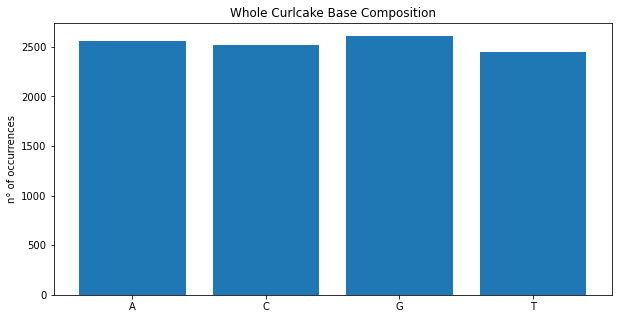

In [13]:
plt.figure(figsize=(10,5))
plt.bar(r.keys(), r.values())
plt.title("Whole Curlcake Base Composition")
plt.ylabel("n° of occurrences")
plt.show()

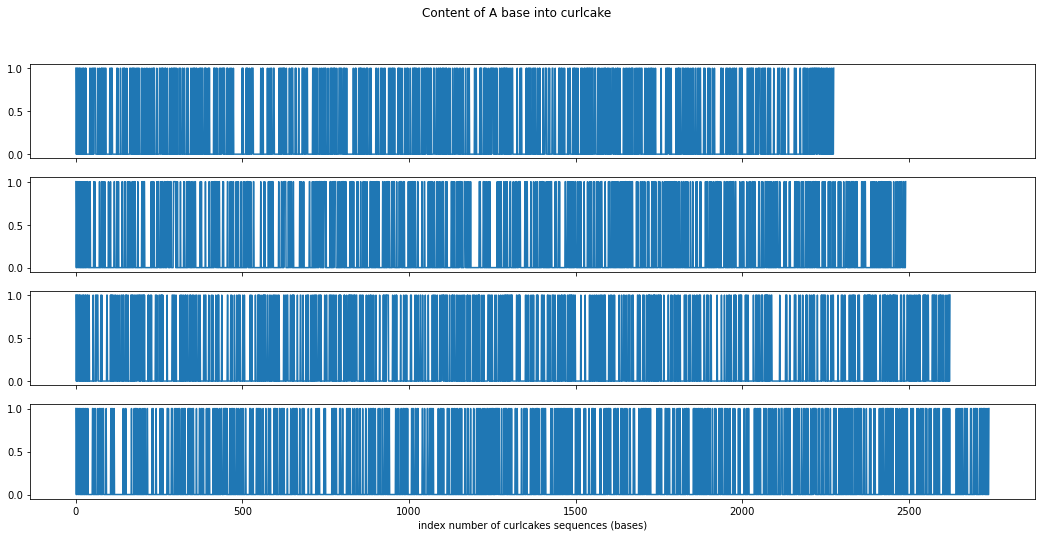

In [100]:
encoded_whole_curlcake = []
for i in whole_curlcake:
    if i == "A":
        encoded_whole_curlcake.append(1)
    else:
        encoded_whole_curlcake += [0]
fig, axes = plt.subplots(4,1, figsize=(18,8), sharex=True)
axes[0].plot(encoded_whole_curlcake[:2276])
axes[1].plot(encoded_whole_curlcake[2276:4768])
axes[2].plot(encoded_whole_curlcake[4768:7393])
axes[3].plot(encoded_whole_curlcake[7393:10135])
axes[3].set_xlabel("index number of curlcakes sequences (bases)")
fig.suptitle("Content of A base into curlcake")
plt.show()

In [50]:
windows=[]
base_step=5
for i in range(len(whole_curlcake)-4):
    kmer = whole_curlcake[i:i+5]
    a_perc = kmer.count("A") / 5 * 100
    windows.append(a_perc)
windows = np.array(windows)
windows.shape

(10131,)

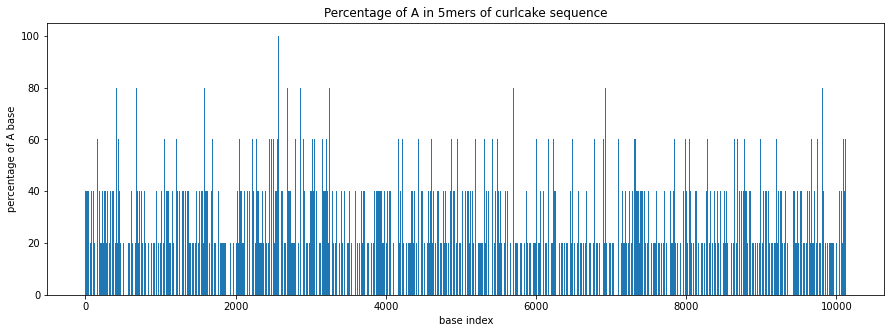

In [99]:
plt.figure(figsize=(15, 5))
plt.bar(range(len(windows)), windows)
plt.title("Percentage of A in 5mers of curlcake sequence")
plt.xlabel("base index")
plt.ylabel("percentage of A base")
plt.show()

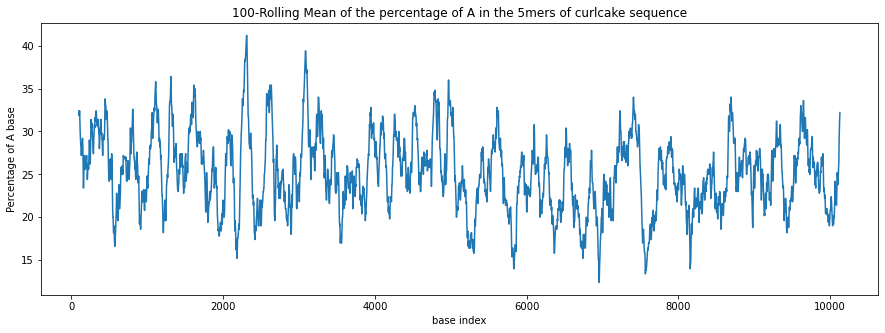

In [104]:
import pandas as pd
df_windows = pd.DataFrame(windows)
df_windows.rolling(100).mean().plot(figsize=(15,5), legend=False)
plt.title("100-Rolling Mean of the percentage of A in the 5mers of curlcake sequence")
plt.xlabel("base index")
plt.ylabel("Percentage of A base")
plt.show()

and now I'm going to perform a k-mers analysis

In [63]:
kmers_5 = {}
for i in range(len(whole_curlcake)-4):
    kmer = whole_curlcake[i:i+5]
    #print(i, i+5, "--->", whole_curlcake[i:i+5])
    if kmer not in kmers_5.keys():
        #print("not in...adding it,")
        kmers_5[kmer] = 1
    else:
        kmers_5[kmer] += 1
print(kmers_5)

{'ATCAT': 13, 'TCATA': 13, 'CATAA': 15, 'ATAAT': 16, 'TAATT': 11, 'AATTA': 9, 'ATTAA': 11, 'TTAAT': 11, 'TAATA': 17, 'AATAC': 12, 'ATACG': 14, 'TACGA': 14, 'ACGAC': 12, 'CGACT': 11, 'GACTC': 17, 'ACTCA': 16, 'CTCAC': 16, 'TCACT': 19, 'CACTA': 14, 'ACTAT': 14, 'CTATA': 11, 'TATAG': 15, 'ATAGG': 14, 'TAGGG': 14, 'AGGGA': 15, 'GGGAG': 17, 'GGAGA': 12, 'GAGAT': 6, 'AGATC': 9, 'GATCC': 8, 'ATCCG': 7, 'TCCGG': 5, 'CCGGC': 10, 'CGGCT': 8, 'GGCTG': 11, 'GCTGT': 9, 'CTGTG': 10, 'TGTGG': 13, 'GTGGA': 14, 'TGGAA': 9, 'GGAAG': 9, 'GAAGT': 12, 'AAGTC': 9, 'AGTCG': 11, 'GTCGA': 14, 'TCGAT': 10, 'CGATG': 7, 'GATGA': 6, 'ATGAA': 6, 'TGAAT': 13, 'GAATC': 11, 'AATCA': 19, 'ATCAA': 12, 'TCAAA': 13, 'CAAAA': 8, 'AAAAA': 15, 'AAAAC': 10, 'AAACC': 9, 'AACCT': 9, 'ACCTT': 11, 'CCTTG': 11, 'CTTGG': 14, 'TTGGA': 14, 'TGGAC': 12, 'GGACC': 14, 'GACCC': 15, 'ACCCT': 15, 'CCCTA': 14, 'CCTAT': 12, 'CTATC': 9, 'TATCT': 10, 'ATCTC': 10, 'TCTCA': 9, 'TCACA': 7, 'CACAA': 10, 'ACAAC': 15, 'CAACG': 13, 'AACGA': 13, 'ACGA

In [104]:
print("Uniques 5-mers into the curlcake are:", len(kmers_5.keys()))

Uniques 5-mers into the curlcake are: 1024


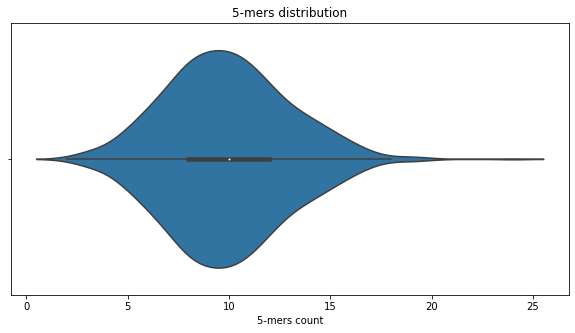

In [105]:
plt.figure(figsize=(10,5))
sn.violinplot(list(kmers_5.values()), dodge="False")
plt.title("5-mers distribution")
plt.xlabel("5-mers count")
plt.show()